In [ ]:
#hide
#Run once per session
!pip install fastai fastcore wwf fastaudio -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 KB 7.9 MB/s eta 0:00:00
ERROR: wwf has an invalid wheel, wwf has an invalid wheel, multiple .dist-info directories found: wwf-0.0.10.dist-info, wwf-0.0.11.dist-info


In [ ]:
!pip install fastaudio

In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

In [ ]:
path_dig = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [ ]:
fnames = get_files(path_dig, extensions=audio_extensions)

In [ ]:
fnames[:5]

(#5) [Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00258.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00185.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00405.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00085.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00095.wav')]

We can convert any audio file to a tensor with `AudioTensor`. Let's try opening a file:

In [ ]:
at = AudioTensor.create(fnames[0])

In [ ]:
at, at.shape

(AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           6.1035e-05, -3.3569e-04]]), torch.Size([1, 81280]))

<AxesSubplot:>

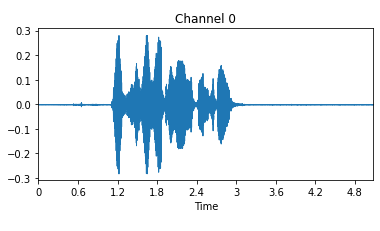

In [ ]:
at.show()

In [ ]:
cfg = AudioConfig.Voice()

In [ ]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

In [ ]:
aud2spec = AudioToSpec.from_cfg(cfg)

In [ ]:
crop1s = ResizeSignal(1000)

In [ ]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

In [ ]:
item_tfms = [ResizeSignal(1000), aud2spec]

In [ ]:
get_y = lambda x: x.name[0]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=64)

In [ ]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [ ]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [ ]:
alter_learner(learn, n_c)

Now we can find our learning rate and fit!

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.002511886414140463)

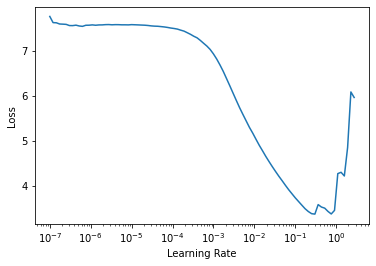

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.184973,0.417043,0.837240,00:14
1,0.422015,0.093563,0.962240,00:13
2,0.191552,0.745327,0.842448,00:14
3,0.094900,0.291604,0.904948,00:19
4,0.058929,0.033952,0.989583,00:17


In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.030099,0.034156,0.986979,00:11
1,0.031116,0.021291,0.996094,00:12
2,0.032417,0.017661,0.997396,00:11
3,0.025745,0.017490,0.994792,00:11
4,0.022410,0.016554,0.997396,00:11


Not bad for zero data augmentation! But let's see if augmentation can help us out here!

## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [ ]:
aud2spec.settings

{'mel': 'True',
 'to_db': 'False',
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 50.0,
 'f_max': 8000.0,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'center': True,
 'pad_mode': 'reflect',
 'onesided': True,
 'norm': None,
 'stype': 'power',
 'top_db': None,
 'sr': 16000,
 'nchannels': 1}

And we'll narrow this down a bit

In [ ]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

Now let's rebuild our `DataBlock`:

In [ ]:
item_tfms = [RemoveSilence(), ResizeSignal(1000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

Let's look at some augmented data:

Let's try training again. Also, since we have to keep making an adustment to our model, let's make an `audio_learner` function similar to `cnn_learner`:

In [ ]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.650460,1.274344,0.776042,00:17
1,1.882244,0.165905,0.928385,00:17
2,0.958342,0.023563,0.993490,00:17
3,0.537469,0.020922,0.994792,00:17
4,0.317845,0.012210,0.996094,00:17
5,0.193368,0.030548,0.990885,00:17
6,0.118598,0.014498,0.996094,00:17
7,0.074519,0.002216,1.000000,00:17
8,0.047171,0.003482,1.000000,00:17
9,0.030317,0.002047,1.000000,00:17


In [ ]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.003665,0.003438,1.000000,00:17
1,0.004991,0.003278,1.000000,00:17
2,0.005746,0.017678,0.997396,00:17
3,0.005073,0.002702,0.998698,00:17
4,0.003955,0.002549,1.000000,00:17
5,0.003551,0.001628,1.000000,00:17
6,0.003751,0.001688,1.000000,00:17
7,0.003312,0.003636,0.998698,00:17
8,0.003430,0.003046,1.000000,00:17
9,0.003002,0.002288,1.000000,00:17


With the help of some of our data augmentation, we were able to perform a bit higher!

## Mel Frequency Cepstral Coefficient (MFCC)

Now let's look at that MFCC option we said earlier. MFCC's are a "linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency" - Wikipedia. But what does that mean?

![](https://www.researchgate.net/publication/335398843/figure/fig1/AS:796124961058818@1566822390492/MFCC-mel-frequency-cepstral-coefficients-characteristic-vectors-extraction-flow.png)

Let's try it out!

In [ ]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,
                                             'n_mels':128})

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc]

There's a shortcut for replacing the item transforms in a `DataBlock`:

In [ ]:
aud_digit.item_tfms

(#8) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ,Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,RemoveSilence:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,MaskTime:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ,MaskFreq:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

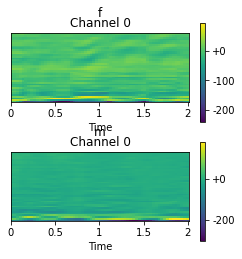

In [ ]:
dls.show_batch(max_n=3)

Now let's build our learner and train again!

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0020892962347716093)

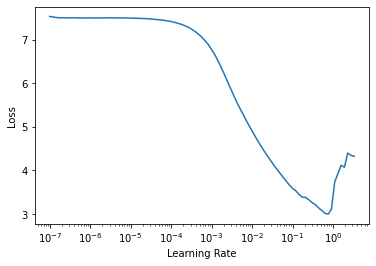

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.969720,1.324741,0.812500,00:09
1,0.805437,0.774530,0.738281,00:09
2,0.427395,0.071427,0.970052,00:09
3,0.251631,0.052916,0.980469,00:09
4,0.156765,0.026019,0.989583,00:09


Now we can begin to see why choosing your augmentation is important!

## MFCC + Delta:

The last transform we'll discuss is the `Delta` transform:

> Local estimate of the derivative of the input data along the selected axis.

This allows multiple-channeled inputs from one signal

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc, Delta()]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

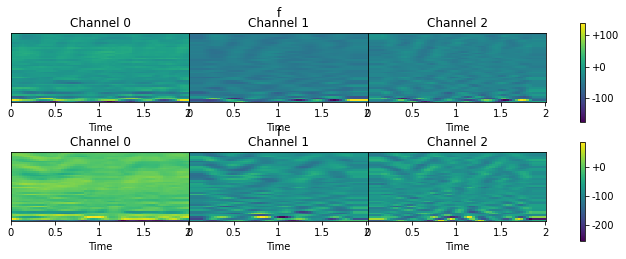

In [ ]:
dls.show_batch(max_n=3)

Let's try training one more time:

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0014454397605732083)

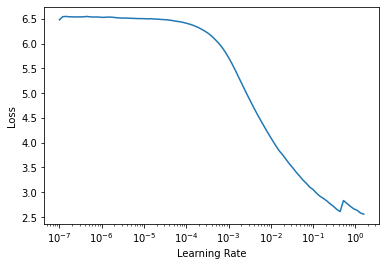

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.581891,0.626583,0.882812,00:13
1,0.678377,0.197535,0.912760,00:13
2,0.367090,0.094837,0.962240,00:13
3,0.220476,0.022505,0.992188,00:13
4,0.141336,0.033642,0.988281,00:13


Let's try fitting for a few more:

In [ ]:
learn.fit_one_cycle(5, 1e-2/10)

epoch,train_loss,valid_loss,accuracy,time
0,0.029490,0.022874,0.993490,00:13
1,0.027482,0.022706,0.992188,00:13
2,0.025360,0.015615,0.994792,00:13
3,0.026397,0.026350,0.990885,00:13
4,0.027179,0.022311,0.993490,00:13
